In [10]:
import torch
import numpy as np

import sys
sys.path.append('..')

from data.pde_data import PDEData
from models.pinn_strategy import StrategicGeneralizedPINN, GeneralizedStrongFormLoss, GeneralizedWeakFormLoss, GeneralizedMultiFidelityLoss
from training.trainer_strategy import StrategicPINNTrainer
from utils.plotter import plot_solution, plot_time_slices
from utils.test_functions import generate_compact_gaussians, plot_compact_gaussians

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful.")

Imports successful.


# Heat Equation

$\frac{\partial u}{\partial t} = \alpha\,\frac{\partial^2 u}{\partial x^2}$

 - **Forward Problem**: Given $\alpha$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $\alpha$

In [2]:
from pdes.heat import HeatEquation1D

heat_pde = HeatEquation1D(
    params={'alpha': 0.01}, 
    domain={'L': 1.0, 'T': 1.0}, 
    device='cpu'
)

## Data generation

PDEData initialized for HeatEquation1D:
  Domain: x in [0, 1.0], t in [0, 1.0]
  Collocation: 10000, BC: 100, IC: 100
  Measurements: 10 sensors x 10 times

Generating dataset for HeatEquation1D...
Measurements generated (analytical):
  Total: 100 points
  SNR: 41.4 dB
Dataset generation complete.
Figure saved to ../results/heat/base_data.png


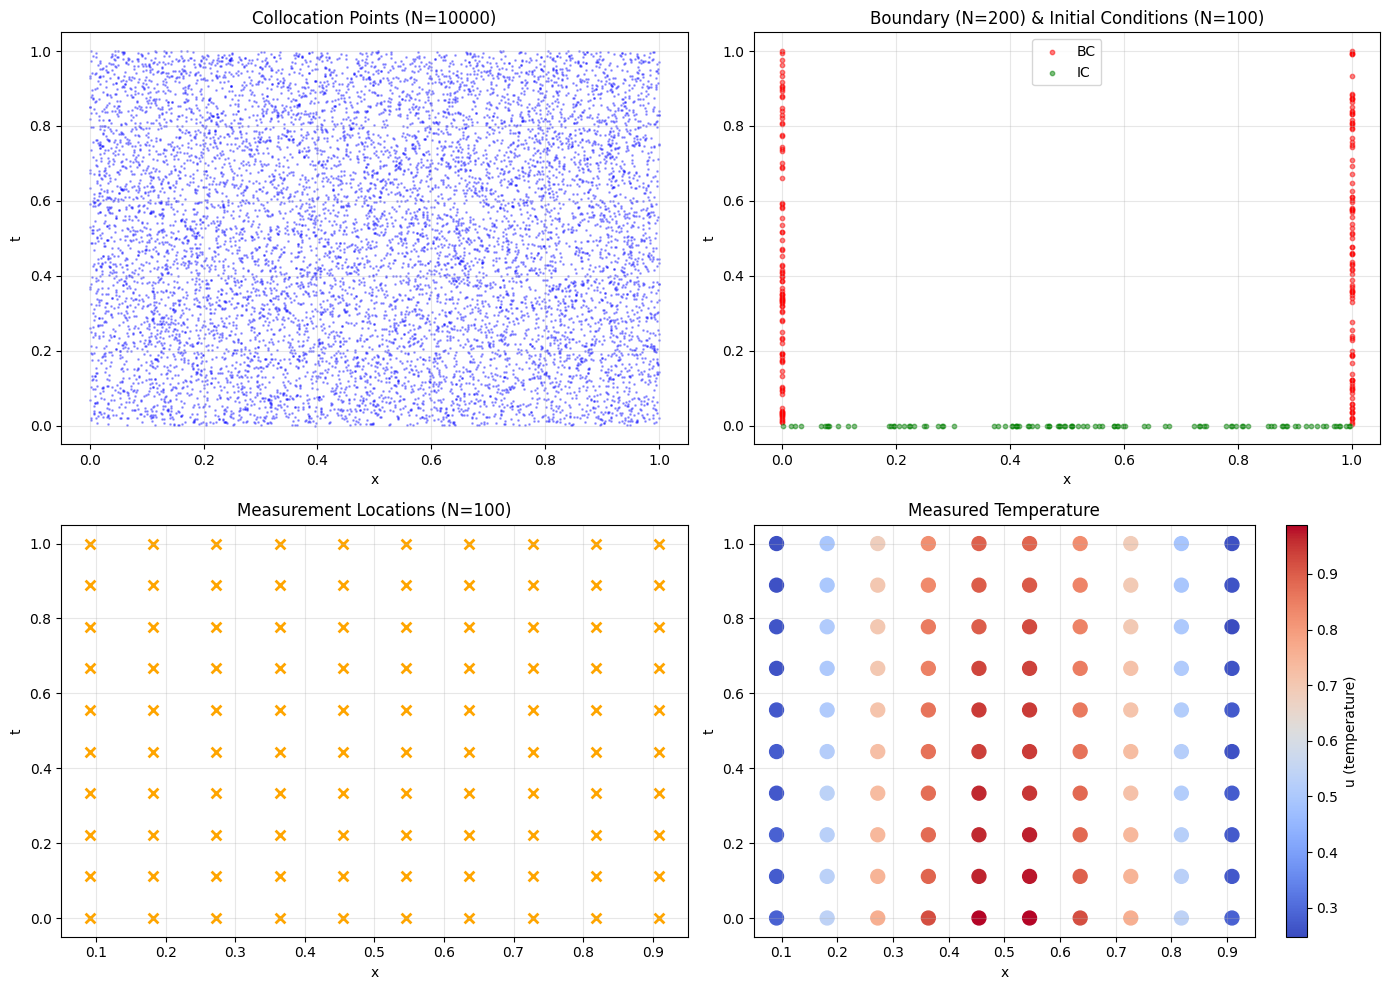

In [3]:
heat_data_gen = PDEData(
    pde=heat_pde,
    N_f=10000,              # Number of collocation points
    N_bc=100,               # BC points
    N_ic=100,               # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu',
    random_seed=42
)

# Generate dataset
heat_data = heat_data_gen.generate_full_dataset(
    collocation_method='uniform',   # Uniform collocation points
    include_measurements=True,      # Include measures for inverse problems
)

# Visualize dataset
heat_data_gen.visualize_data(heat_data, save_path='../results/heat/base_data.png')

## Test functions for weak form

Uniform Placement: Successfully placed 49/50 test functions on 7×7 grid
Figure saved to ../results/heat/test_functions.png


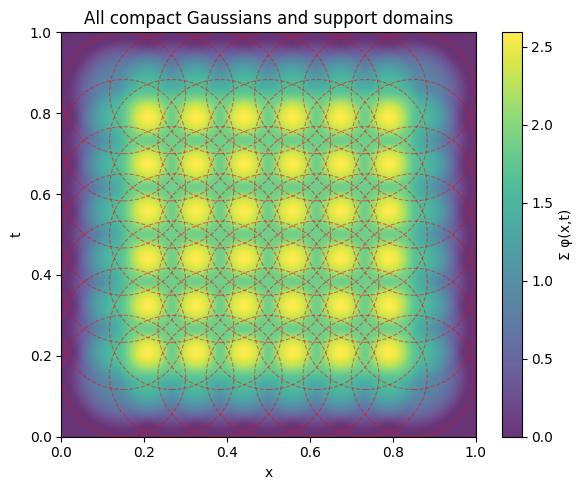

In [ ]:
heat_test_funcs, heat_test_doms = generate_compact_gaussians(
    L=heat_pde.L,                                       # Domain L from PDE
    T=heat_pde.T,                                       # Domain T from PDE
    n_funcs=50,                                         # Number of test functions
    support_radius=0.15*min(heat_pde.L, heat_pde.T),    # Support radius of test functions
    placement='uniform',                                # Placement of test functions
    min_separation=0.05*min(heat_pde.L, heat_pde.T),    # Minimum separation
    smooth=0.0)                                         # Heaviside smoothing

plot_compact_gaussians(
    test_funcs=heat_test_funcs, 
    test_doms=heat_test_doms,
    show_support=True,
    domain=[[0, heat_pde.L], [0, heat_pde.T]],
    save_path='../results/heat/test_functions.png'
)

## Multi-fidelity data

In [7]:
heat_data_mf = heat_data_gen.generate_multi_fidelity_data(
    hf_sensors=5,                                                   # Number of high-fidelity sensors
    hf_times=5,                                                     # Number of high-fidelity time-measurements
    lf_nx=21,                                                       # Low-fidelity x resolution
    lf_nt=21,                                                       # Low-fidelity t resolution
    lf_param_error={'alpha': 1.2*heat_pde.get_param('alpha')},      # Low-fidelity PDE parameter perturbation (20 %)
    lf_noise=0.05,                                                  # Low-fidelity noise level (5 %)
    collocation_method='uniform',
)


Generating multi-fidelity data for HeatEquation1D...
Measurements generated (analytical):
  Total: 25 points
  SNR: 40.2 dB
High-fidelity: 25 points, σ=0.0071
Low-fidelity: 380 points, σ=0.0324
Effective weight ratio (HF/LF): 20.8x


## Forward problem

### Strong form

In [ ]:
heat_model_strong_forward = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=None,            # Forward problem
    param_init=None,                # Use value from PDE
    device='cpu'
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: alpha=0.01
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss


Trainer initialized:
  Loss strategy: GeneralizedStrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 4.104050e-01
  Residual: 3.522986e-03 (λ=1.00)
  Boundary: 2.051611e-02 (λ=1.00)
  Initial: 3.863659e-01 (λ=1.00)

Epoch 1000/5000 (123.6s)
  Adam learning rate: 1.00e-03
  Total: 1.907739e-04
  Residual: 2.097491e-05 (λ=3.55)
  Boundary: 6.307895e-05 (λ=0.65)
  Initial: 8.865448e-05 (λ=0.85)

Epoch 2000/5000 (247.0s)
  Adam learning rate: 1.00e-03
  Total: 4.185605e-05
  Residual: 8.616106e-06 (λ=2.69)
  Boundary: 1.355017e-05 (λ=0.66)
  Initial: 1.080769e-05 (λ=0.90)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at Epoch 2681
   Reason: Plateau detected (var=0.096150, slope=0.000516)
   Loss before swi

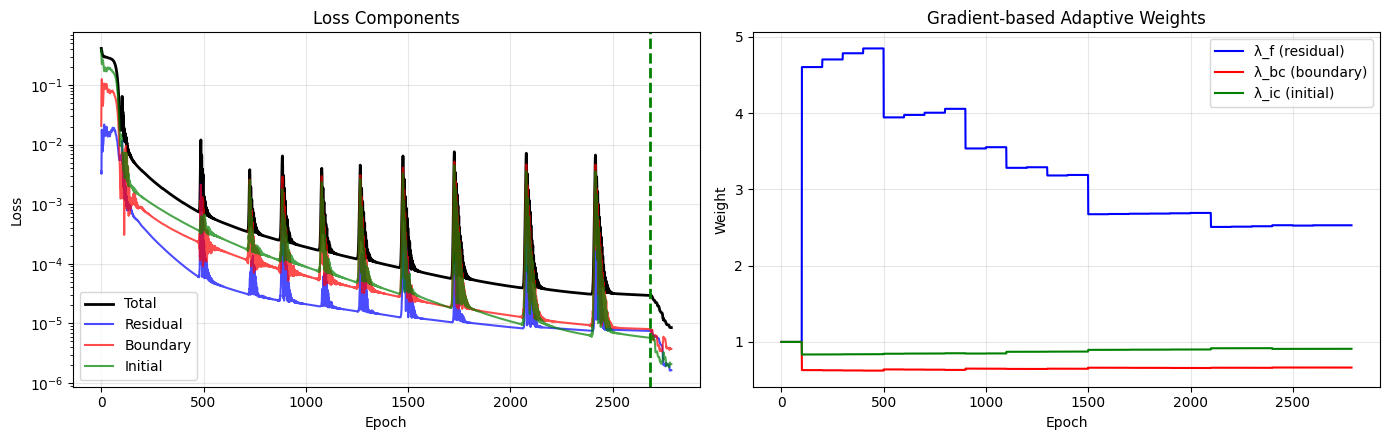


Training complete. Time: 341.2s


In [9]:
heat_trainer_strong_forward = StrategicPINNTrainer(
    model=heat_model_strong_forward,    
    data=heat_data,
    learning_rate=1e-3,                 # Adam LR
    reduce_lr_patience=100,             # Epoch patience before reducing LR after plateau
    switch_var=0.1,                     # Variation condition for L-BFGS switch
    switch_slope=0.001,                 # Slope condition for L-BFGS switch
    switch_window=200,                  # Epoch window to check for var and slope
    min_adam_epochs=1000,               # Mininum number of Adam epochs before L-BFGS
    track_gradient_norms=False,         # Do not track gradient norms
    adaptive_weights=True,              # Use adaptive weights
)

# Train
heat_trainer_strong_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

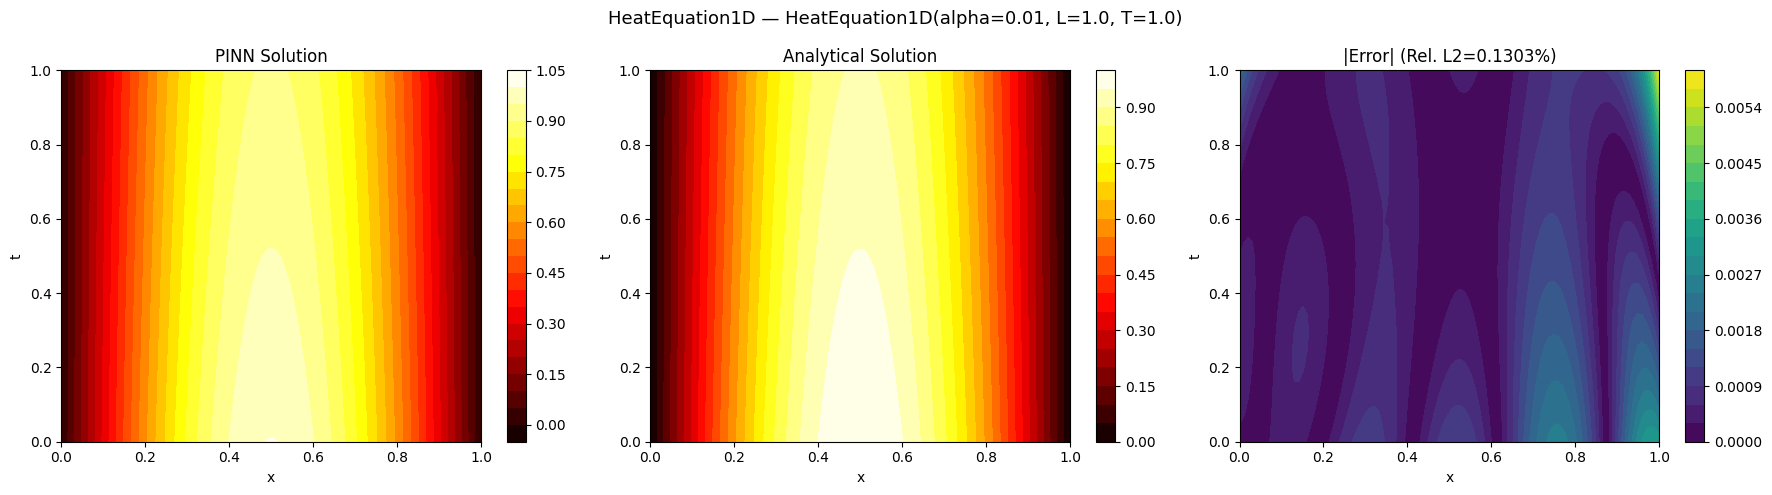

In [10]:
plot_solution(
    model=heat_model_strong_forward,
    data=heat_data,
    save_path='../results/heat/forward_strong_340s.png'
)

### Weak form

In [17]:
# Prepare weak-form data
replacements = {'x_f': ('test_funcs', heat_test_funcs), 't_f': ('test_doms', heat_test_doms)}
heat_data_weak = {}
for k, v in heat_data.items():
    new_k, new_v = replacements.get(k, (k,v))
    heat_data_weak[new_k] = new_v

# Define model
heat_model_weak_forward = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=None,            # Forward problem
    param_init=None,                # Use value from PDE
    device='cpu'
)

# Set to weak form
heat_model_weak_forward.set_loss_strategy(
    GeneralizedWeakFormLoss(
        integration_method='simpson',   # Choice of integrator
        n_integration_points=7         # Number of integration points
    )
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: alpha=0.01
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss
GeneralizedWeakFormLoss initialized:
  Method: simpson
  Points: 7
Loss strategy changed to GeneralizedWeakFormLoss


Trainer initialized:
  Loss strategy: GeneralizedWeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 6.470500e-01
  Residual: 8.574226e-06 (λ=1.00)
  Boundary: 2.283203e-02 (λ=1.00)
  Initial: 6.242094e-01 (λ=1.00)
  Non-zero weak residuals: 49

Epoch 1000/5000 (234.1s)
  Adam learning rate: 1.00e-03
  Total: 2.601136e-04
  Residual: 3.404258e-07 (λ=114.23)
  Boundary: 8.111219e-05 (λ=0.65)
  Initial: 2.459843e-04 (λ=0.68)
  Non-zero weak residuals: 49

Epoch 2000/5000 (464.6s)
  Adam learning rate: 1.00e-03
  Total: 6.028525e-05
  Residual: 6.637704e-08 (λ=137.40)
  Boundary: 2.049734e-05 (λ=0.64)
  Initial: 5.443004e-05 (λ=0.70)
  Non-zero weak residuals: 49

Epoch 3000/5000 (696.4s)
  Adam learning rate: 1.00e-03
  

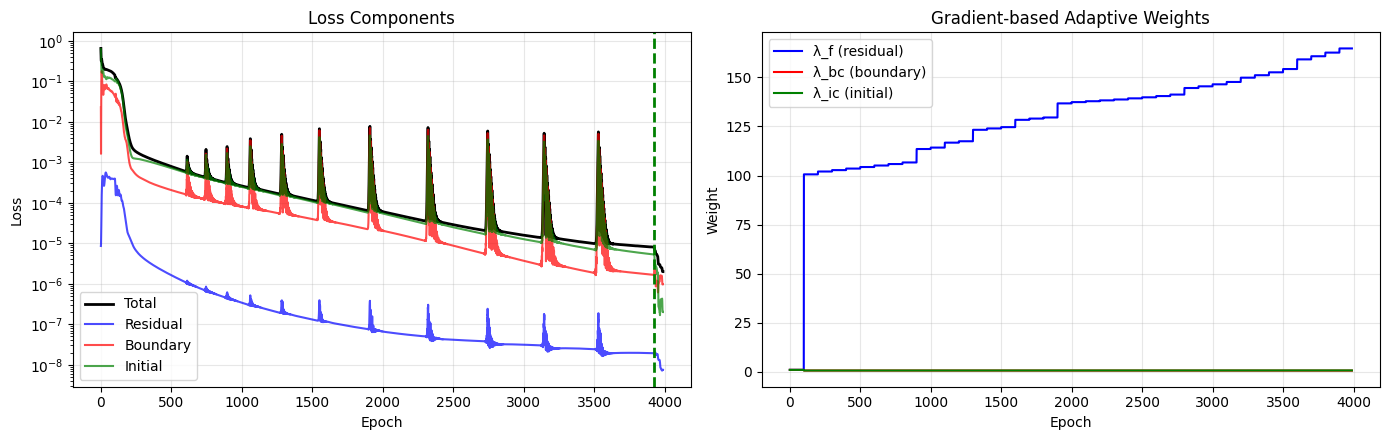


Training complete. Time: 934.8s


In [18]:
heat_trainer_weak_forward = StrategicPINNTrainer(
    model=heat_model_weak_forward,
    data=heat_data_weak,
    learning_rate=1e-3,
    reduce_lr_patience=100,
    switch_var=0.1,
    switch_slope=0.001,
    switch_window=200,
    min_adam_epochs=1000,
    track_gradient_norms=False,
    adaptive_weights=True,
)

# Train
heat_trainer_weak_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

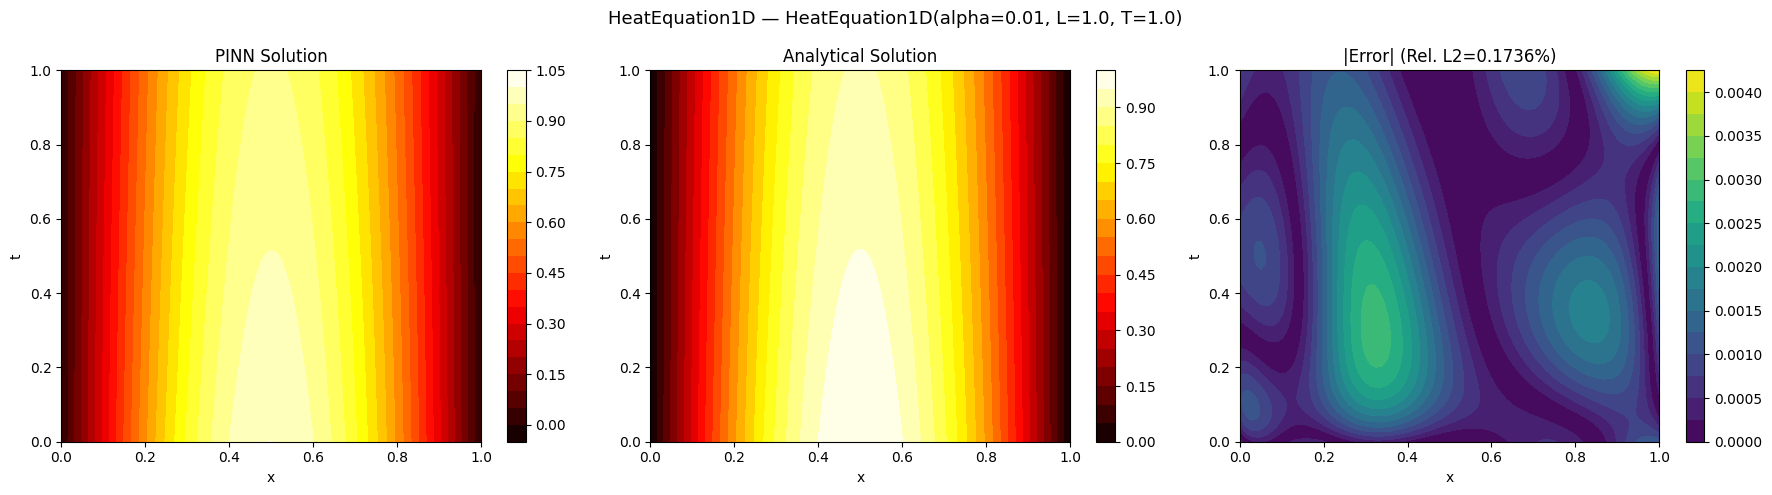

In [ ]:
plot_solution(
    model=heat_model_weak_forward,
    data=heat_data_weak,
    save_path='../results/heat/forward_weak_Simpson7_930s'
)

### Multi-fidelity

In [20]:
heat_model_mf_forward = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],
    activation='tanh',
    inverse_params=None,            
    param_init=None,
    device='cpu'
)

heat_model_mf_forward.set_loss_strategy(
    GeneralizedMultiFidelityLoss(
        weighting='uncertainty',
        lambda_hf=1.0,
        lambda_lf=0.1,
        device='cpu'
    )
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: alpha=0.01
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss
GeneralizedMultiFidelityLoss initialized:
  Weighting: uncertainty
Loss strategy changed to GeneralizedMultiFidelityLoss


Trainer initialized:
  Loss strategy: GeneralizedMultiFidelityLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.4s)
  Adam learning rate: 1.00e-03
  Total: 1.120848e+00
  Residual: 4.849619e-02 (λ=1.00)
  Boundary: 8.686103e-02 (λ=1.00)
  Initial: 9.854909e-01 (λ=1.00)

Epoch 1000/5000 (230.2s)
  Adam learning rate: 1.00e-03
  Total: 9.081865e-05
  Residual: 1.308418e-05 (λ=4.31)
  Boundary: 1.034704e-05 (λ=0.73)
  Initial: 3.775500e-05 (λ=0.71)

Epoch 2000/5000 (355.7s)
  Adam learning rate: 1.00e-03
  Total: 3.050086e-05
  Residual: 4.710359e-06 (λ=4.37)
  Boundary: 5.859875e-06 (λ=0.71)
  Initial: 7.830469e-06 (λ=0.73)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at Epoch 2981
   Reason: Plateau detected (var=0.099604, slope=0.000587)
   Loss before 

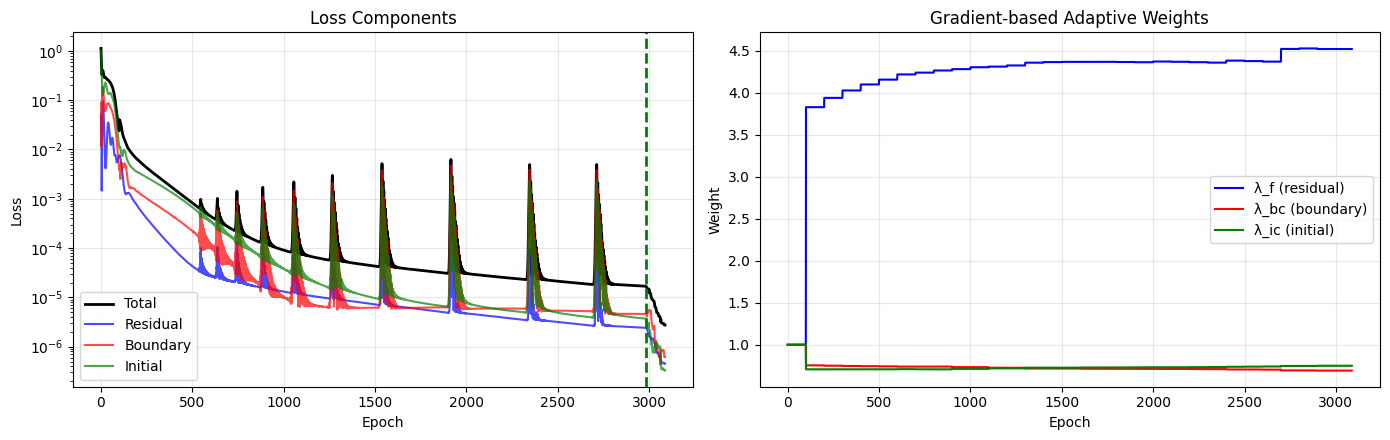


Training complete. Time: 586.2s


In [21]:
heat_trainer_mf_forward = StrategicPINNTrainer(
    model=heat_model_mf_forward,
    data=heat_data_mf,
    learning_rate=1e-3,
    reduce_lr_patience=100,
    switch_var=0.1,
    switch_slope=0.001,
    switch_window=200,
    min_adam_epochs=1000,
    track_gradient_norms=False,
    adaptive_weights=True,
)

heat_trainer_mf_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

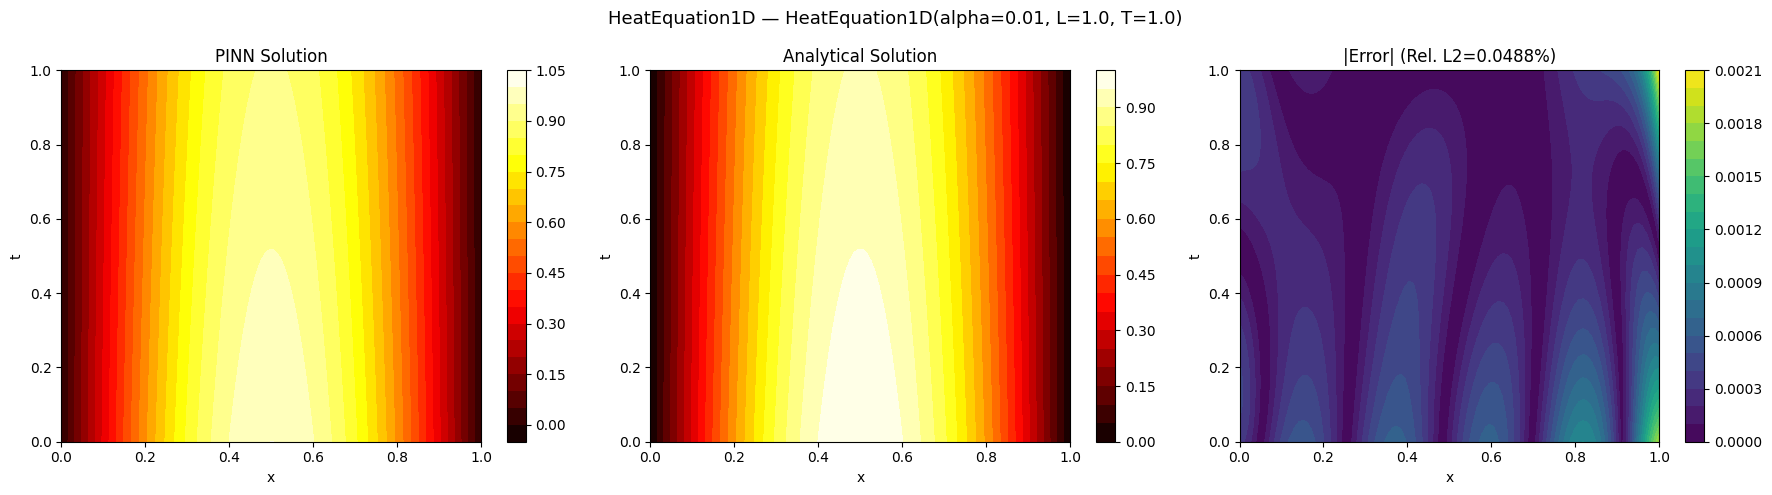

In [22]:
plot_solution(
    model=heat_model_mf_forward,
    data=heat_data_mf,
    save_path='../results/heat/forward_mf_20x_585s'
)

## Inverse problem

### Strong form

In [24]:
heat_model_strong_inverse = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=['alpha'],       # Learn parameter
    param_init={'alpha': 0.03},     # Initial guess
    device='cpu'
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7852
  Mode: Inverse problem
    Learning: alpha (init=0.0300)
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss


Trainer initialized:
  Loss strategy: GeneralizedStrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse
  Learning: ['alpha']

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 1.268740e+00
  Residual: 7.619992e-02 (λ=1.00)
  Boundary: 1.901592e-02 (λ=1.00)
  Initial: 4.917310e-01 (λ=1.00)
  Measurement: 6.817930e-01 (λ=1.00)
  alpha: 0.031000 (true: 0.01)

Epoch 1000/5000 (235.6s)
  Adam learning rate: 1.00e-03
  Total: 4.181355e-03
  Residual: 2.045589e-04 (λ=1.29)
  Boundary: 2.104649e-03 (λ=0.63)
  Initial: 1.015180e-03 (λ=1.40)
  Measurement: 1.077632e-03 (λ=1.09)
  alpha: 0.007675 (true: 0.01)

Epoch 2000/5000 (509.9s)
  Adam learning rate: 1.00e-03
  Total: 2.283112e-04
  Residual: 3.908093e-05 (λ=1.46)
  Boundary: 4.881176e-05 (λ=0.61)
  Initial: 4.892008e-05 (λ

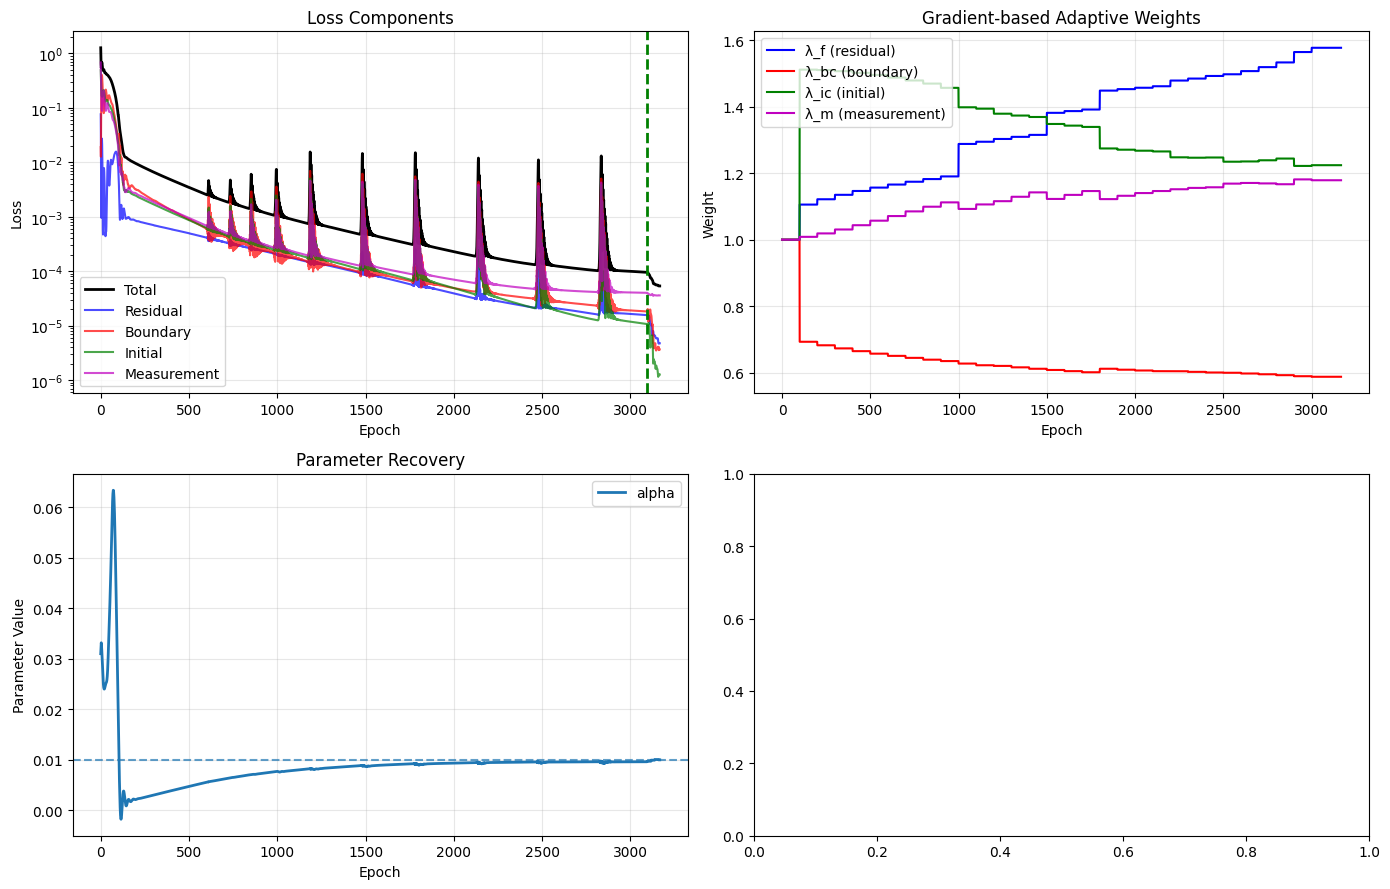


Training complete. Time: 821.3s


In [25]:
heat_trainer_strong_inverse = StrategicPINNTrainer(
    model=heat_model_strong_inverse,    
    data=heat_data,
    learning_rate=1e-3,                 # Adam LR
    reduce_lr_patience=100,             # Epoch patience before reducing LR after plateau
    switch_var=0.1,                     # Variation condition for L-BFGS switch
    switch_slope=0.001,                 # Slope condition for L-BFGS switch
    switch_window=200,                  # Epoch window to check for var and slope
    min_adam_epochs=1000,               # Mininum number of Adam epochs before L-BFGS
    track_gradient_norms=False,         # Do not track gradient norms
    adaptive_weights=True,              # Use adaptive weights
)

# Train
heat_trainer_strong_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

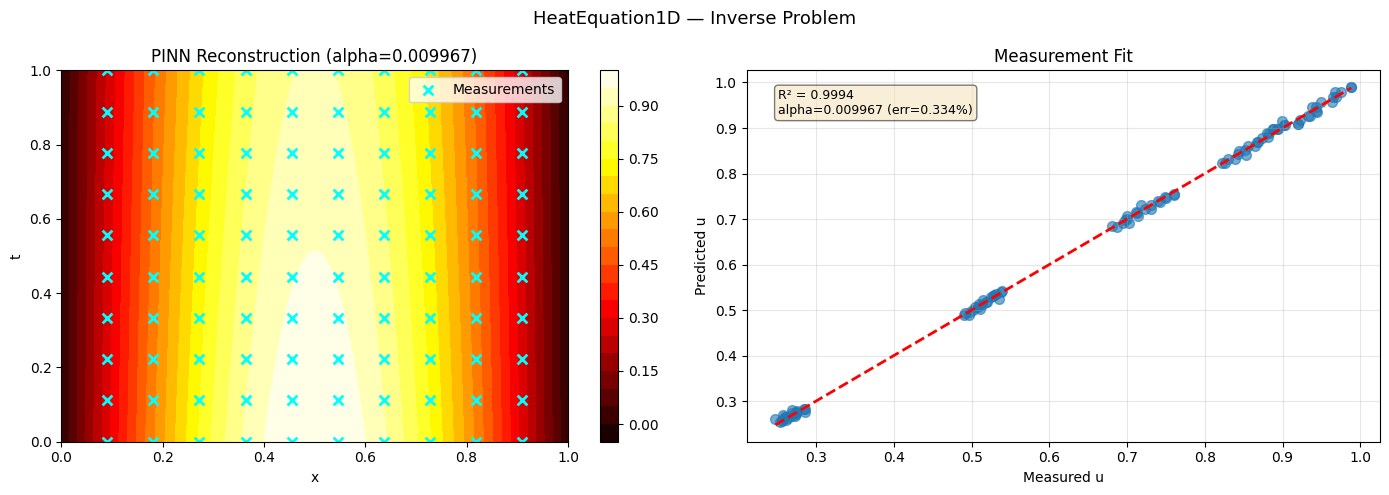

In [26]:
plot_solution(
    model=heat_model_strong_inverse,
    data=heat_data,
    save_path='../results/heat/inverse_strong_820s.png'
)

### Weak form

In [27]:
heat_model_weak_inverse = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=['alpha'],       # Inverse problem
    param_init={'alpha': 0.03},     # Initial guess
    device='cpu'
)

# Set to weak form
heat_model_weak_inverse.set_loss_strategy(
    GeneralizedWeakFormLoss(
        integration_method='simpson',  # Choice of integrator
        n_integration_points=7         # Number of integration points
    )
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7852
  Mode: Inverse problem
    Learning: alpha (init=0.0300)
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss
GeneralizedWeakFormLoss initialized:
  Method: simpson
  Points: 7
Loss strategy changed to GeneralizedWeakFormLoss


Trainer initialized:
  Loss strategy: GeneralizedWeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse
  Learning: ['alpha']

Starting training...

Epoch 0/5000 (0.7s)
  Adam learning rate: 1.00e-03
  Total: 1.111204e+00
  Residual: 9.515750e-05 (λ=1.00)
  Boundary: 2.442444e-02 (λ=1.00)
  Initial: 4.246727e-01 (λ=1.00)
  Measurement: 6.620116e-01 (λ=1.00)
  alpha: 0.031000 (true: 0.01)
  Non-zero weak residuals: 49

Epoch 1000/5000 (199.5s)
  Adam learning rate: 1.00e-03
  Total: 3.355530e-04
  Residual: 2.120132e-07 (λ=157.44)
  Boundary: 8.147452e-05 (λ=0.52)
  Initial: 1.017185e-04 (λ=1.45)
  Measurement: 1.544509e-04 (λ=0.73)
  alpha: 0.010172 (true: 0.01)
  Non-zero weak residuals: 49

Epoch 2000/5000 (347.9s)
  Adam learning rate: 1.00e-03
  Total: 1.198368e-04
  Residual: 8.932983e-08 (λ=206.86

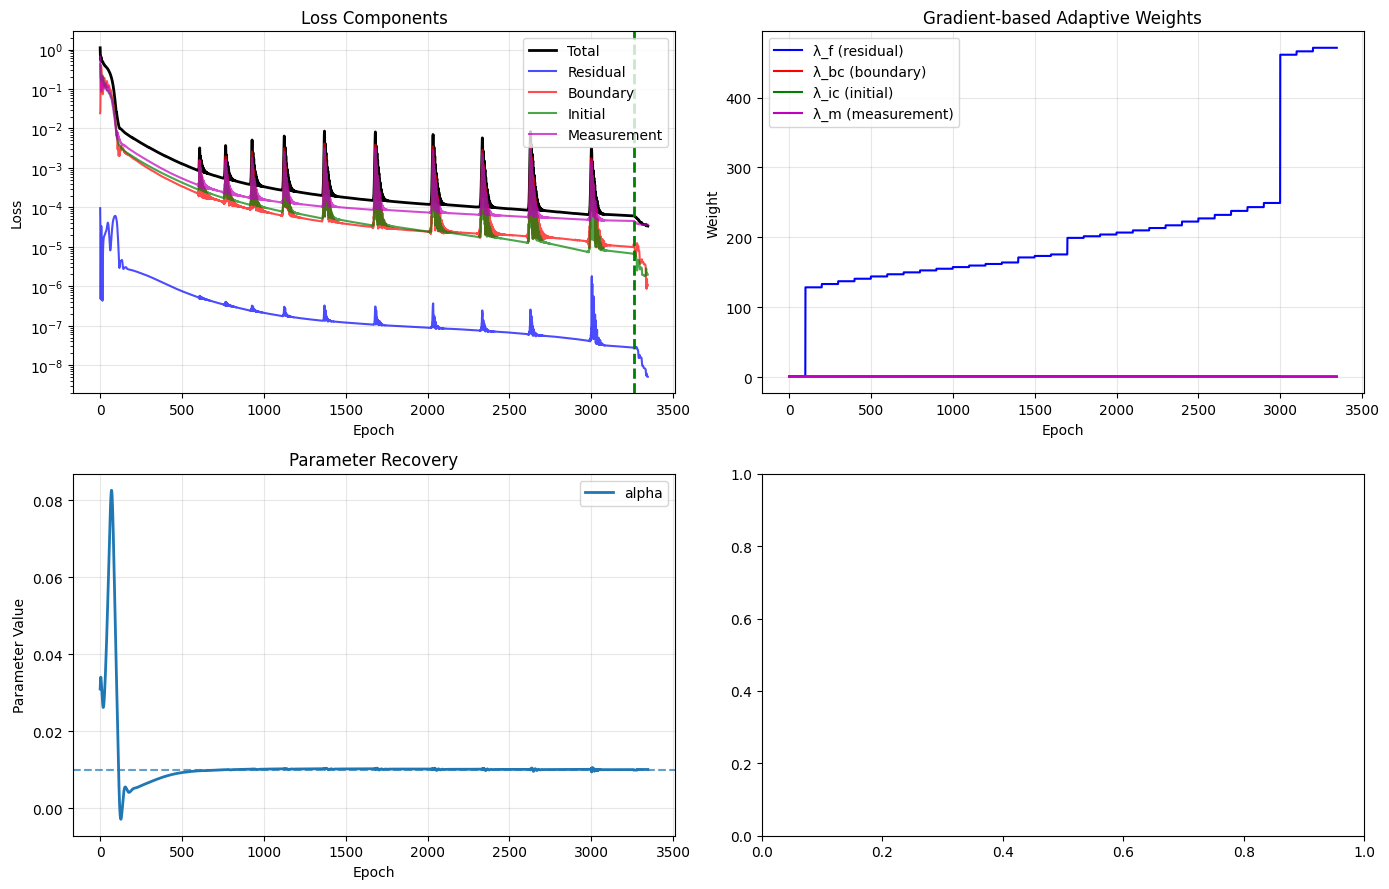


Training complete. Time: 554.1s


In [28]:
heat_trainer_weak_inverse = StrategicPINNTrainer(
    model=heat_model_weak_inverse,    
    data=heat_data_weak,
    learning_rate=1e-3,                 # Adam LR
    reduce_lr_patience=100,             # Epoch patience before reducing LR after plateau
    switch_var=0.1,                     # Variation condition for L-BFGS switch
    switch_slope=0.001,                 # Slope condition for L-BFGS switch
    switch_window=200,                  # Epoch window to check for var and slope
    min_adam_epochs=1000,               # Mininum number of Adam epochs before L-BFGS
    track_gradient_norms=False,         # Do not track gradient norms
    adaptive_weights=True,              # Use adaptive weights
)

# Train
heat_trainer_weak_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

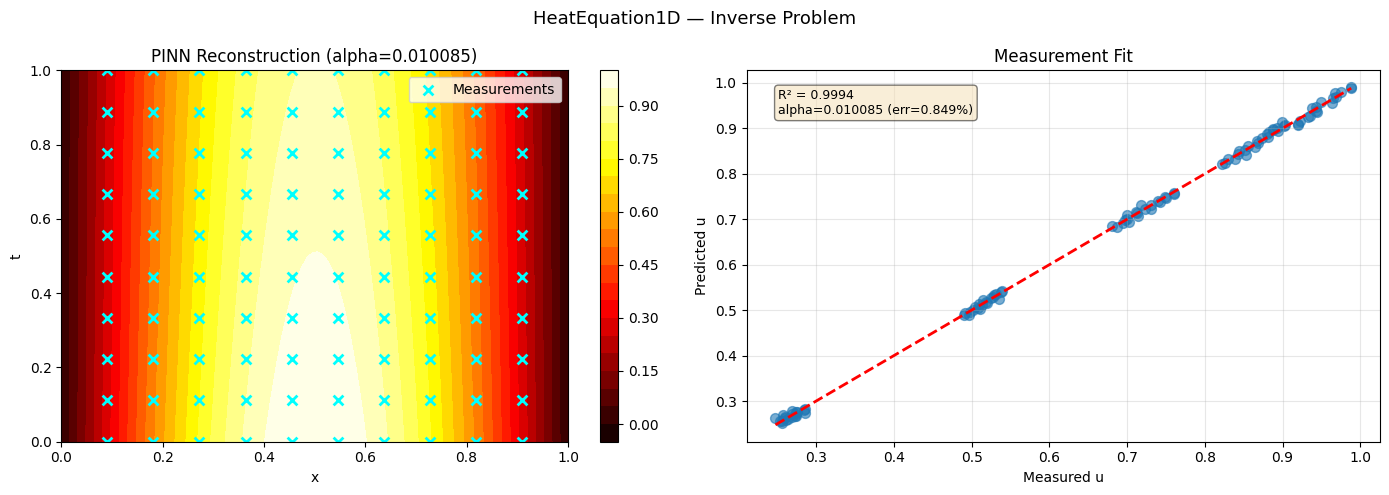

In [29]:
plot_solution(
    model=heat_model_weak_inverse,
    data=heat_data_weak,
    save_path='../results/heat/inverse_weak_Simpson7_555s.png'
)

### Multi-fidelity

In [30]:
heat_model_mf_inverse = StrategicGeneralizedPINN(
    pde=heat_pde,
    layers=[2, 50, 50, 50, 50, 1],
    activation='tanh',
    inverse_params=['alpha'],            
    param_init={'alpha': 0.03},
    device='cpu'
)

heat_model_mf_inverse.set_loss_strategy(
    GeneralizedMultiFidelityLoss(
        weighting='uncertainty',
        lambda_hf=1.0,
        lambda_lf=0.1,
        device='cpu'
    )
)

GeneralizedPINN for HeatEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7852
  Mode: Inverse problem
    Learning: alpha (init=0.0300)
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss
GeneralizedMultiFidelityLoss initialized:
  Weighting: uncertainty
Loss strategy changed to GeneralizedMultiFidelityLoss


Trainer initialized:
  Loss strategy: GeneralizedMultiFidelityLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse
  Learning: ['alpha']

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total: 1.562486e+00
  Residual: 1.011509e-02 (λ=1.00)
  Boundary: 3.692044e-02 (λ=1.00)
  Initial: 7.111120e-01 (λ=1.00)
  Measurement: 8.043381e-01 (λ=1.00)
  alpha: 0.029000 (true: 0.01)

Epoch 1000/5000 (120.9s)
  Adam learning rate: 1.00e-03
  Total: 3.581773e-04
  Residual: 4.786538e-05 (λ=3.34)
  Boundary: 3.714468e-05 (λ=0.54)
  Initial: 5.550242e-05 (λ=1.55)
  Measurement: 1.110610e-04 (λ=0.83)
  alpha: 0.008725 (true: 0.01)

Switching to L-BFGS at Epoch 1795
   Reason: Plateau detected (var=0.099761, slope=0.000587)
   Loss before switch: 1.239154e-04

L-BFGS Step 1/100
  Internal iterations

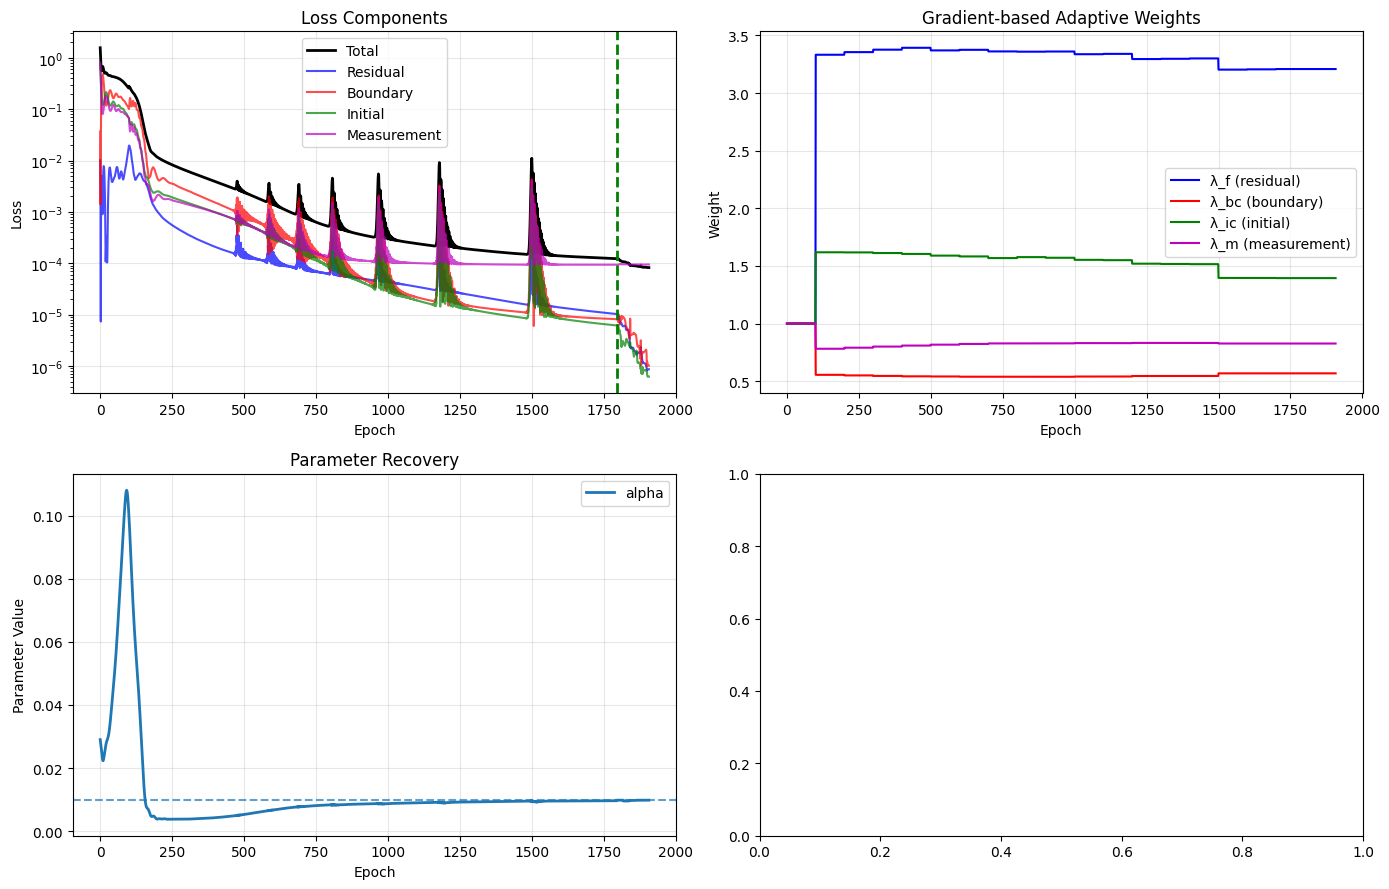


Training complete. Time: 235.5s


In [31]:
heat_trainer_mf_inverse = StrategicPINNTrainer(
    model=heat_model_mf_inverse,
    data=heat_data_mf,
    learning_rate=1e-3,
    reduce_lr_patience=100,
    switch_var=0.1,
    switch_slope=0.001,
    switch_window=200,
    min_adam_epochs=1000,
    track_gradient_norms=False,
    adaptive_weights=True,
)

heat_trainer_mf_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

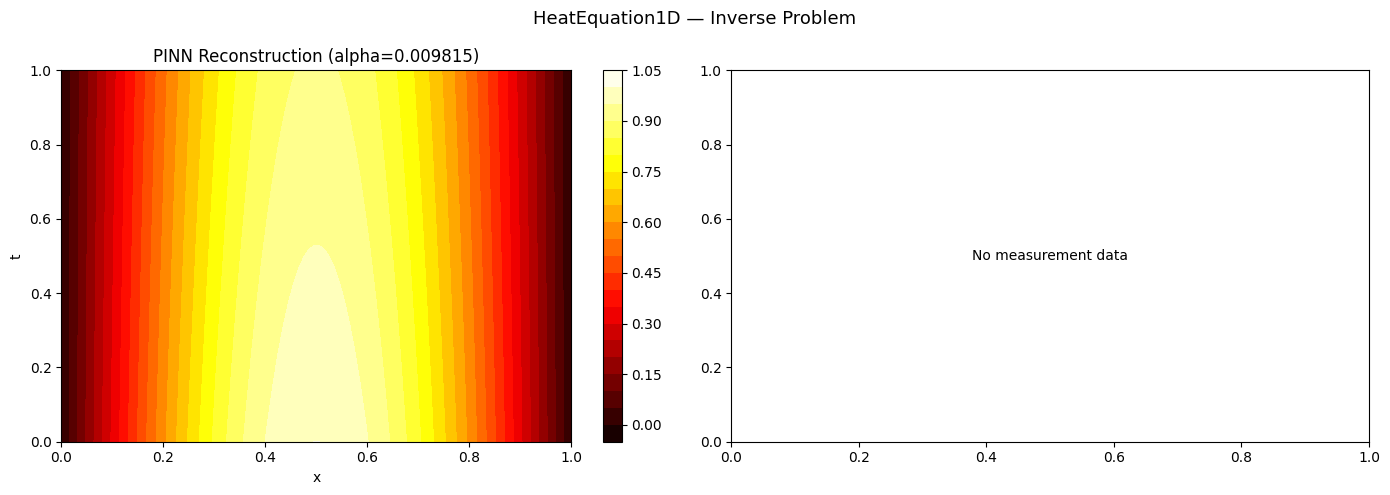

In [32]:
plot_solution(
    model=heat_model_mf_inverse,
    data=heat_data_mf,
    save_path='../results/heat/inverse_mf_20x_235s.png'
)

# Advection Equation

$\frac{\partial u}{\partial t} + c\,\frac{\partial u}{\partial x} = 0$

 - **Forward Problem**: Given $c$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $c$

In [33]:
from pdes.advection import AdvectionEquation1D

adv_pde = AdvectionEquation1D(
    params={'c': 1.0}, 
    domain={'L': 1.0, 'T': 1.0}, 
    device='cpu'
)

## Data generation

PDEData initialized for AdvectionEquation1D:
  Domain: x in [0, 1.0], t in [0, 1.0]
  Collocation: 10000, BC: 100, IC: 100
  Measurements: 10 sensors x 10 times

Generating dataset for AdvectionEquation1D...
Measurements generated (analytical):
  Total: 100 points
  SNR: 41.7 dB
Dataset generation complete.
Figure saved to ../results/advection/base_data.png


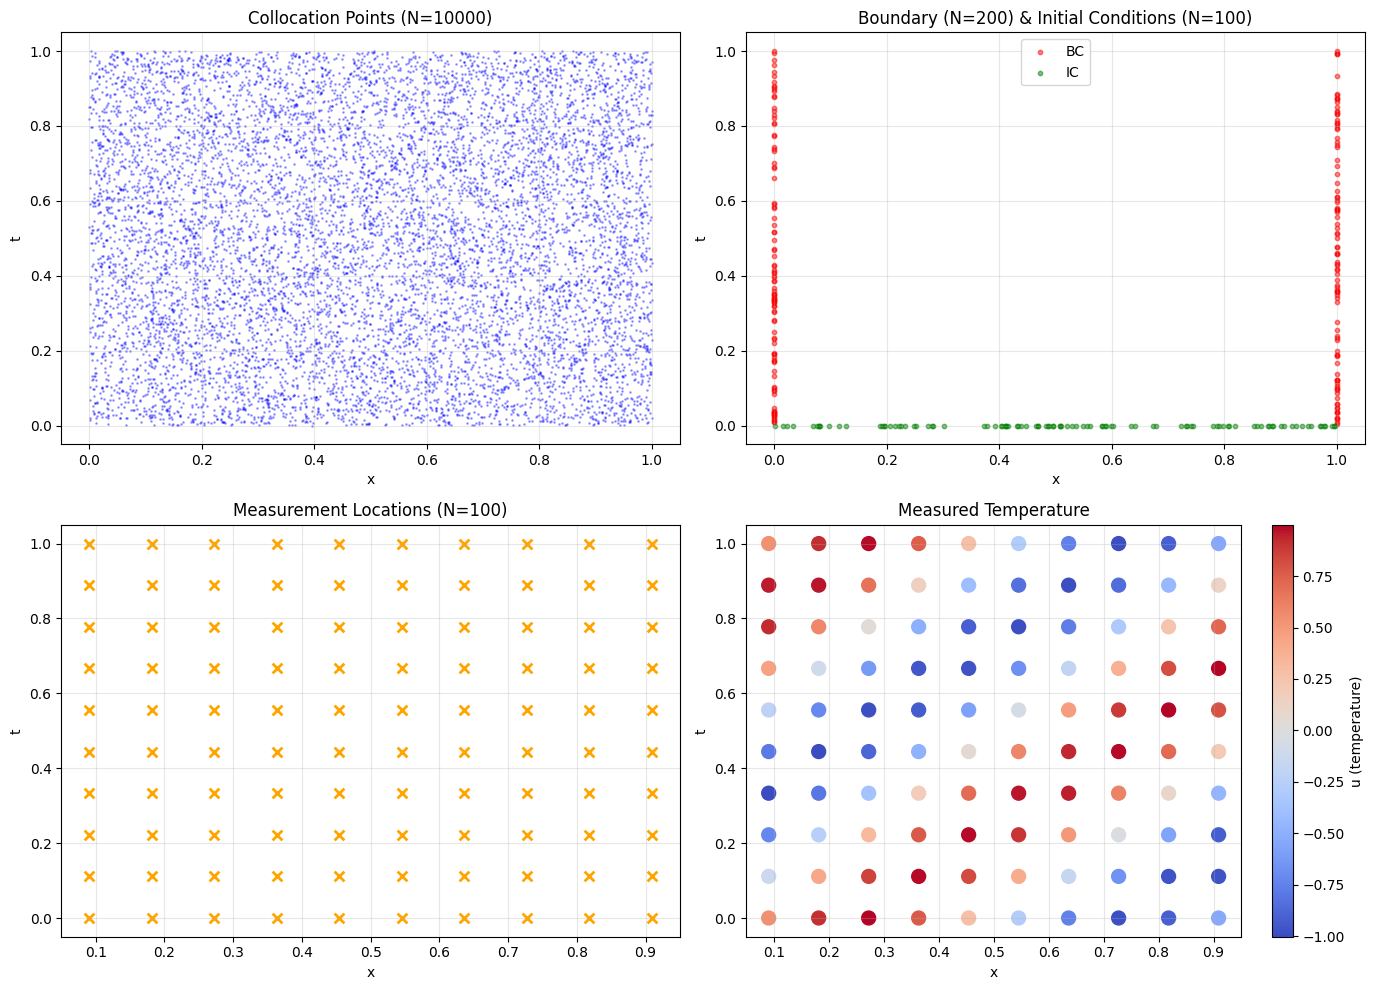

In [34]:
adv_data_gen = PDEData(
    pde=adv_pde,
    N_f=10000,              # Number of collocation points
    N_bc=100,               # BC points
    N_ic=100,               # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu',
    random_seed=42
)

# Generate dataset
adv_data = adv_data_gen.generate_full_dataset(
    collocation_method='uniform',   # Uniform collocation points
    include_measurements=True,      # Include measures for inverse problems
)

# Visualize dataset
adv_data_gen.visualize_data(adv_data, save_path='../results/advection/base_data.png')

## Test functions for weak form

Uniform Placement: Successfully placed 49/50 test functions on 7×7 grid
Figure saved to ../results/advection/test_functions.png


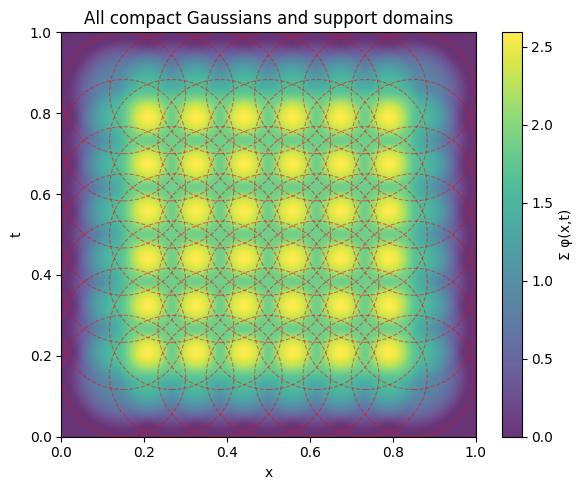

In [35]:
adv_test_funcs, adv_test_doms = generate_compact_gaussians(
    L=adv_pde.L,                                        # Domain L from PDE
    T=adv_pde.T,                                        # Domain T from PDE
    n_funcs=50,                                         # Number of test functions
    support_radius=0.15*min(adv_pde.L, adv_pde.T),      # Support radius of test functions
    placement='uniform',                                # Placement of test functions
    min_separation=0.05*min(adv_pde.L, adv_pde.T),      # Minimum separation
    smooth=0.0)                                         # Heaviside smoothing

plot_compact_gaussians(
    test_funcs=adv_test_funcs, 
    test_doms=adv_test_doms,
    show_support=True,
    domain=[[0, adv_pde.L], [0, adv_pde.T]],
    save_path='../results/advection/test_functions.png'
)

## Multi-fidelity data

In [37]:
adv_data_mf = adv_data_gen.generate_multi_fidelity_data(
    hf_sensors=5,                                           # Number of high-fidelity sensors
    hf_times=5,                                             # Number of high-fidelity time-measurements
    lf_nx=21,                                               # Low-fidelity x resolution
    lf_nt=101,                                              # Low-fidelity t resolution
    lf_param_error={'c': 1.2*adv_pde.get_param('c')},       # Low-fidelity PDE parameter perturbation (20 %)
    lf_noise=0.05,                                          # Low-fidelity noise level (5 %)
    collocation_method='uniform',
)


Generating multi-fidelity data for AdvectionEquation1D...
Measurements generated (analytical):
  Total: 25 points
  SNR: 42.5 dB
High-fidelity: 25 points, σ=0.0066
Low-fidelity: 1900 points, σ=0.3185
Effective weight ratio (HF/LF): 2359.6x


## Forward problem

### Strong form

In [38]:
adv_model_strong_forward = StrategicGeneralizedPINN(
    pde=adv_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=None,            # Forward problem
    param_init=None,                # Use value from PDE
    device='cpu'
)

GeneralizedPINN for AdvectionEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: c=1.0
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss


Trainer initialized:
  Loss strategy: GeneralizedStrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total: 8.310528e-01
  Residual: 5.247987e-04 (λ=1.00)
  Boundary: 4.377846e-01 (λ=1.00)
  Initial: 3.927434e-01 (λ=1.00)

Epoch 1000/5000 (56.4s)
  Adam learning rate: 1.00e-03
  Total: 1.075028e-04
  Residual: 7.700399e-06 (λ=3.20)
  Boundary: 6.643749e-05 (λ=0.88)
  Initial: 3.750909e-05 (λ=0.64)

Epoch 2000/5000 (112.8s)
  Adam learning rate: 1.00e-03
  Total: 1.601942e-05
  Residual: 2.344962e-06 (λ=3.99)
  Boundary: 6.320015e-06 (λ=0.89)
  Initial: 1.641839e-06 (λ=0.61)

Epoch 3000/5000 (168.7s)
  Adam learning rate: 1.00e-03
  Total: 1.139430e-05
  Residual: 1.024231e-06 (λ=3.75)
  Boundary: 4.732474e-06 (λ=0.85)
  Ini

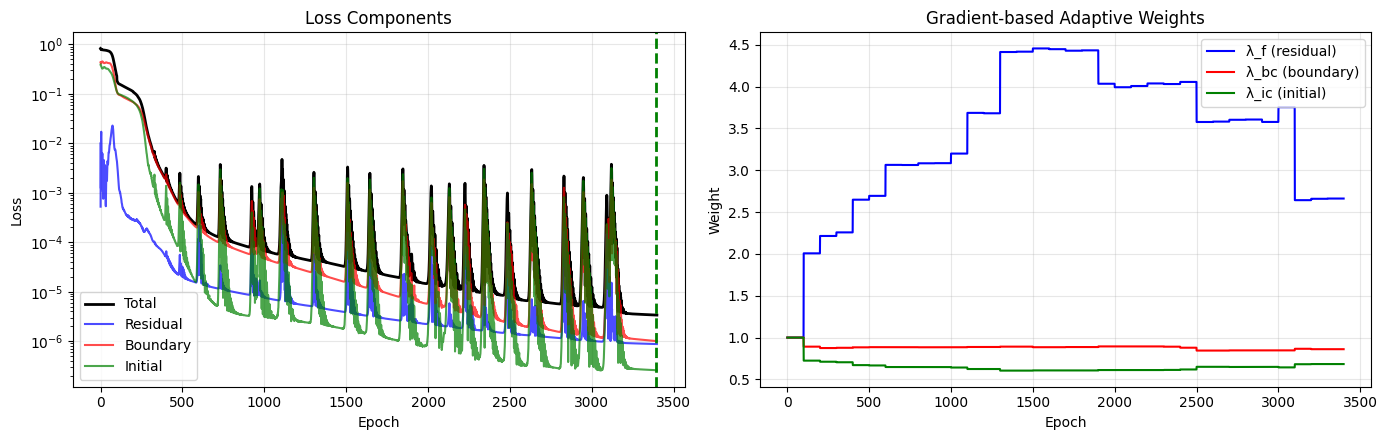


Training complete. Time: 191.2s


In [39]:
adv_trainer_strong_forward = StrategicPINNTrainer(
    model=adv_model_strong_forward,    
    data=adv_data,
    learning_rate=1e-3,                 # Adam LR
    reduce_lr_patience=100,             # Epoch patience before reducing LR after plateau
    switch_var=0.1,                     # Variation condition for L-BFGS switch
    switch_slope=0.001,                 # Slope condition for L-BFGS switch
    switch_window=200,                  # Epoch window to check for var and slope
    min_adam_epochs=1000,               # Mininum number of Adam epochs before L-BFGS
    track_gradient_norms=False,         # Do not track gradient norms
    adaptive_weights=True,              # Use adaptive weights
)

# Train
adv_trainer_strong_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

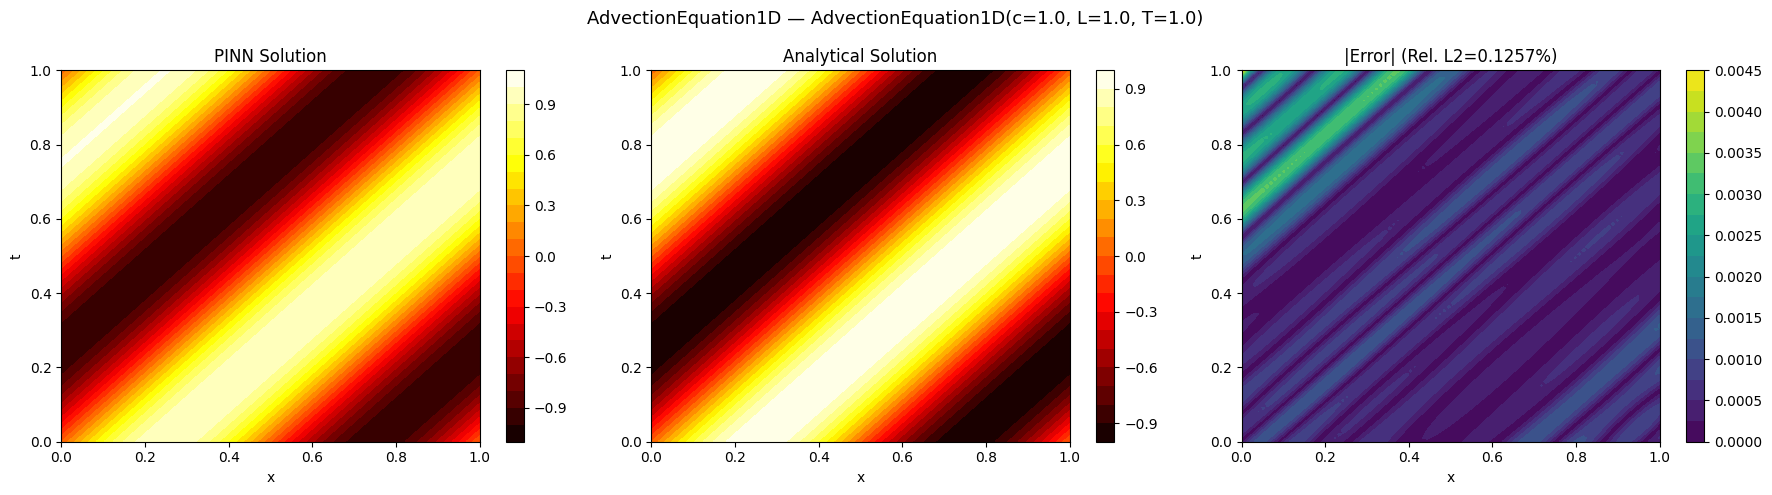

In [40]:
plot_solution(
    model=adv_model_strong_forward,
    data=adv_data,
    save_path='../results/advection/forward_strong_190s.png'
)

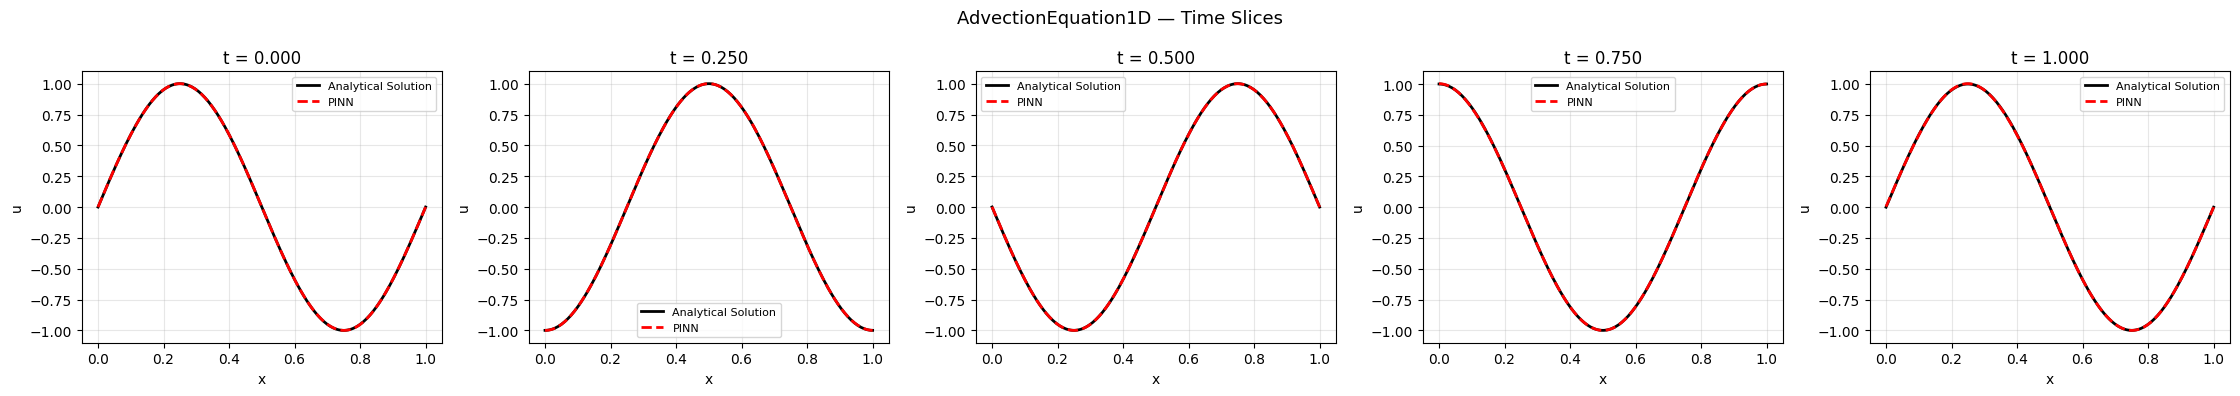

In [42]:
from utils.plotter import plot_time_slices

plot_time_slices(
    model=adv_model_strong_forward, 
    save_path='../results/advection/forward_strong_slices.png'
)

# Burgers Equation

$\frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x} = \nu\,\frac{\partial^2 u}{\partial x^2}$

 - **Large $\nu$**: diffusion-dominated, smooth
 - **Small $\nu$**: convection-dominated, can have shocks

In [18]:
from pdes.burgers import BurgersEquation1D

burgers_pde = BurgersEquation1D(
    params={'nu': 0.01}, 
    domain={'L': 1.0, 'T': 1.0}, 
    device='cpu'
)

## Data generation

PDEData initialized for BurgersEquation1D:
  Domain: x in [0, 1.0], t in [0, 1.0]
  Collocation: 10000, BC: 100, IC: 100
  Measurements: 10 sensors x 10 times

Generating dataset for BurgersEquation1D...
Measurements generated (numerical):
  Total: 100 points
  SNR: 41.8 dB
Dataset generation complete.
Figure saved to ../results/burgers/base_data.png


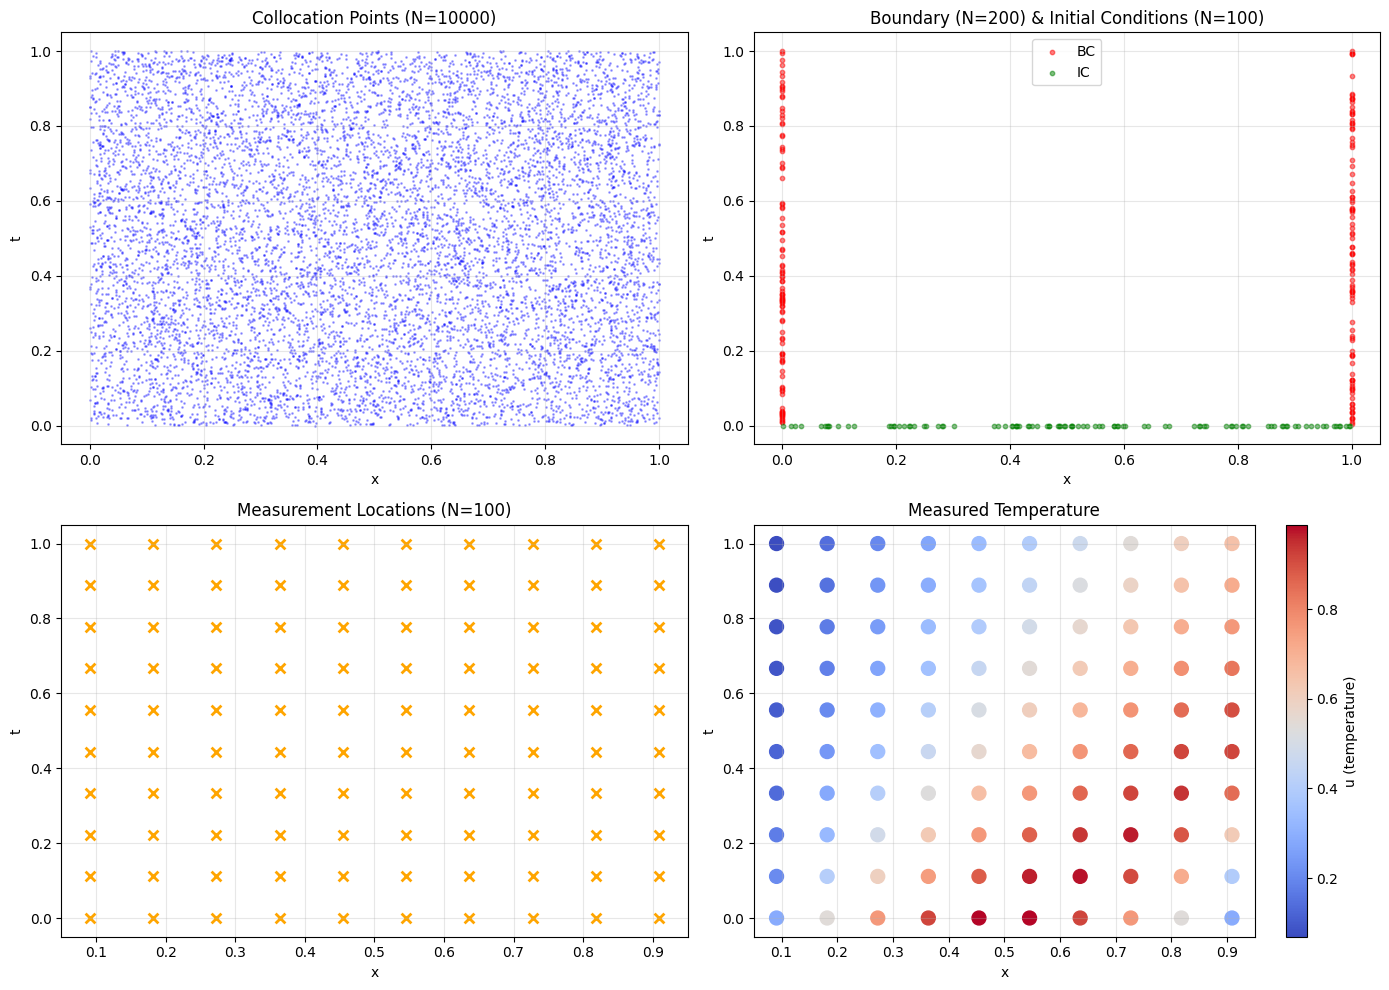

In [19]:
burgers_data_gen = PDEData(
    pde=burgers_pde,
    N_f=10000,              # Number of collocation points
    N_bc=100,               # BC points
    N_ic=100,               # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu',
    random_seed=42
)

# Generate dataset
burgers_data = burgers_data_gen.generate_full_dataset(
    collocation_method='uniform',   # Uniform collocation points
    include_measurements=True,      # Include measures for inverse problems
)

# Visualize dataset
burgers_data_gen.visualize_data(burgers_data, save_path='../results/burgers/base_data.png')

## Test functions for weak form

Uniform Placement: Successfully placed 44/50 test functions on 11×4 grid
Figure saved to ../results/burgers/test_functions.png


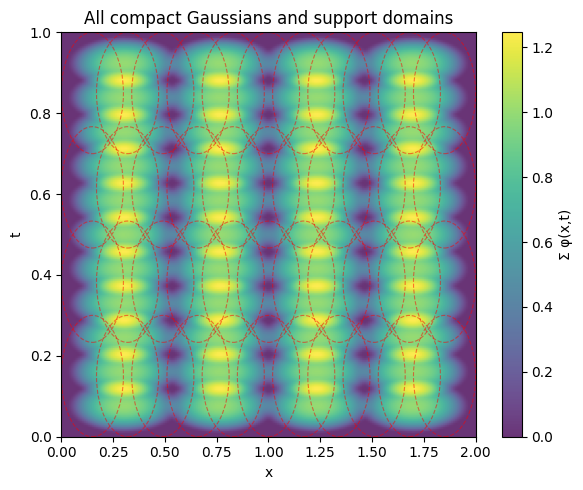

In [5]:
burgers_test_funcs, burgers_test_doms = generate_compact_gaussians(
    L=burgers_pde.L,                                        # Domain L from PDE
    T=burgers_pde.T,                                        # Domain T from PDE
    n_funcs=50,                                             # Number of test functions
    support_radius=0.15*min(burgers_pde.L, burgers_pde.T),  # Support radius of test functions
    placement='uniform',                                    # Placement of test functions
    min_separation=0.05*min(burgers_pde.L, burgers_pde.T),  # Minimum separation
    smooth=0.0)                                             # Heaviside smoothing

plot_compact_gaussians(
    test_funcs=burgers_test_funcs, 
    test_doms=burgers_test_doms,
    show_support=True,
    domain=[[0, burgers_pde.L], [0, burgers_pde.T]],
    save_path='../results/burgers/test_functions.png'
)

## Forward problem

### Strong form

In [6]:
burgers_model_strong_forward = StrategicGeneralizedPINN(
    pde=burgers_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=None,            # Forward problem
    param_init=None,                # Use value from PDE
    device='cpu'
)

GeneralizedPINN for BurgersEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: nu=0.01
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss


Trainer initialized:
  Loss strategy: GeneralizedStrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 6.837748e-01
  Residual: 1.553543e-01 (λ=1.00)
  Boundary: 3.497233e-02 (λ=1.00)
  Initial: 4.934481e-01 (λ=1.00)

Epoch 1000/5000 (155.7s)
  Adam learning rate: 1.00e-03
  Total: 1.660932e-02
  Residual: 1.952789e-03 (λ=2.26)
  Boundary: 1.715470e-03 (λ=1.24)
  Initial: 1.762786e-02 (λ=0.57)

Epoch 2000/5000 (318.2s)
  Adam learning rate: 1.00e-03
  Total: 9.124648e-03
  Residual: 6.702104e-04 (λ=2.65)
  Boundary: 4.513305e-04 (λ=1.52)
  Initial: 1.309531e-02 (λ=0.51)

Epoch 3000/5000 (498.6s)
  Adam learning rate: 1.00e-03
  Total: 6.887310e-03
  Residual: 5.399464e-04 (λ=2.60)
  Boundary: 4.521597e-04 (λ=1.79)
  In

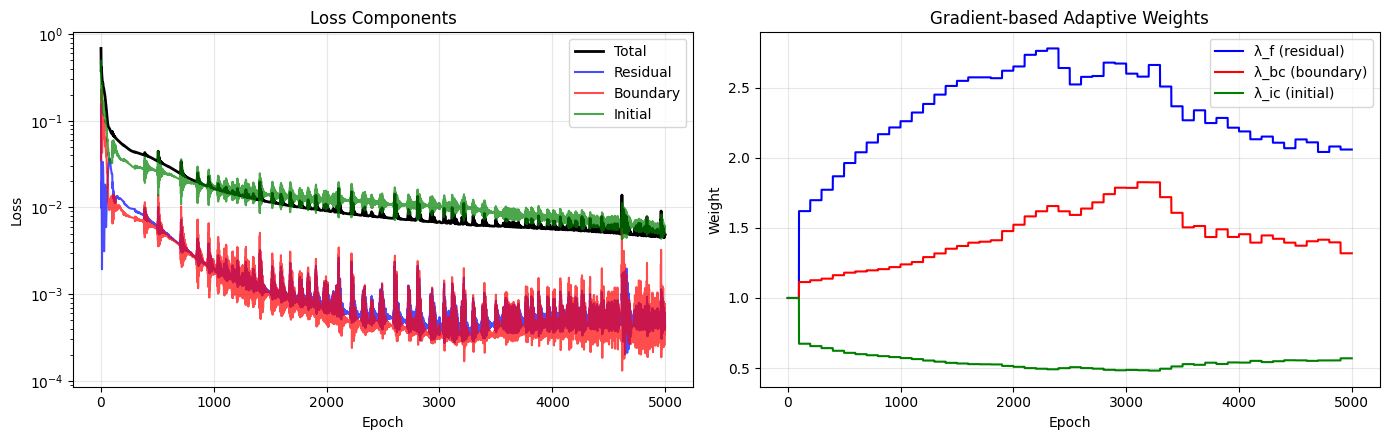


Training complete. Time: 811.8s


In [7]:
burgers_trainer_strong_forward = StrategicPINNTrainer(
    model=burgers_model_strong_forward,    
    data=burgers_data,
    learning_rate=1e-3,                 # Adam LR
    reduce_lr_patience=100,             # Epoch patience before reducing LR after plateau
    switch_var=0.1,                     # Variation condition for L-BFGS switch
    switch_slope=0.001,                 # Slope condition for L-BFGS switch
    switch_window=200,                  # Epoch window to check for var and slope
    min_adam_epochs=1000,               # Mininum number of Adam epochs before L-BFGS
    track_gradient_norms=False,         # Do not track gradient norms
    adaptive_weights=True,              # Use adaptive weights
)

# Train
burgers_trainer_strong_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

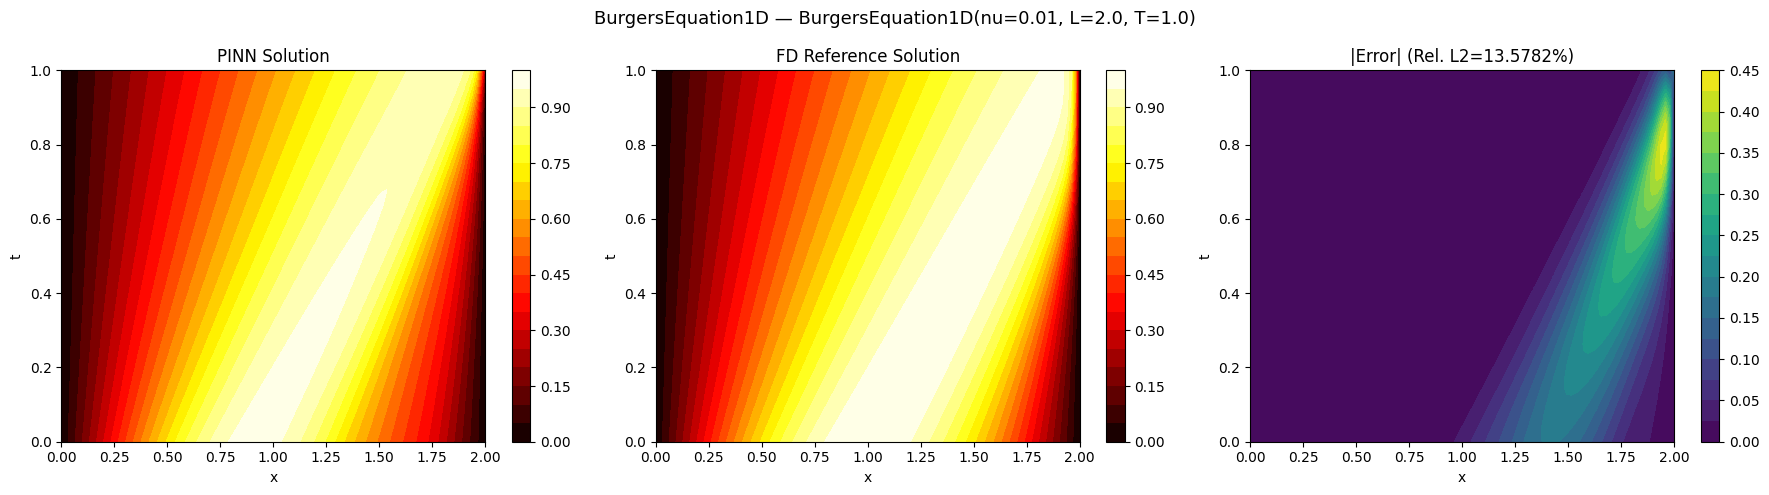

In [8]:
plot_solution(
    model=burgers_model_strong_forward,
    data=burgers_data,
    save_path='../results/burgers/forward_strong_810s.png'
)

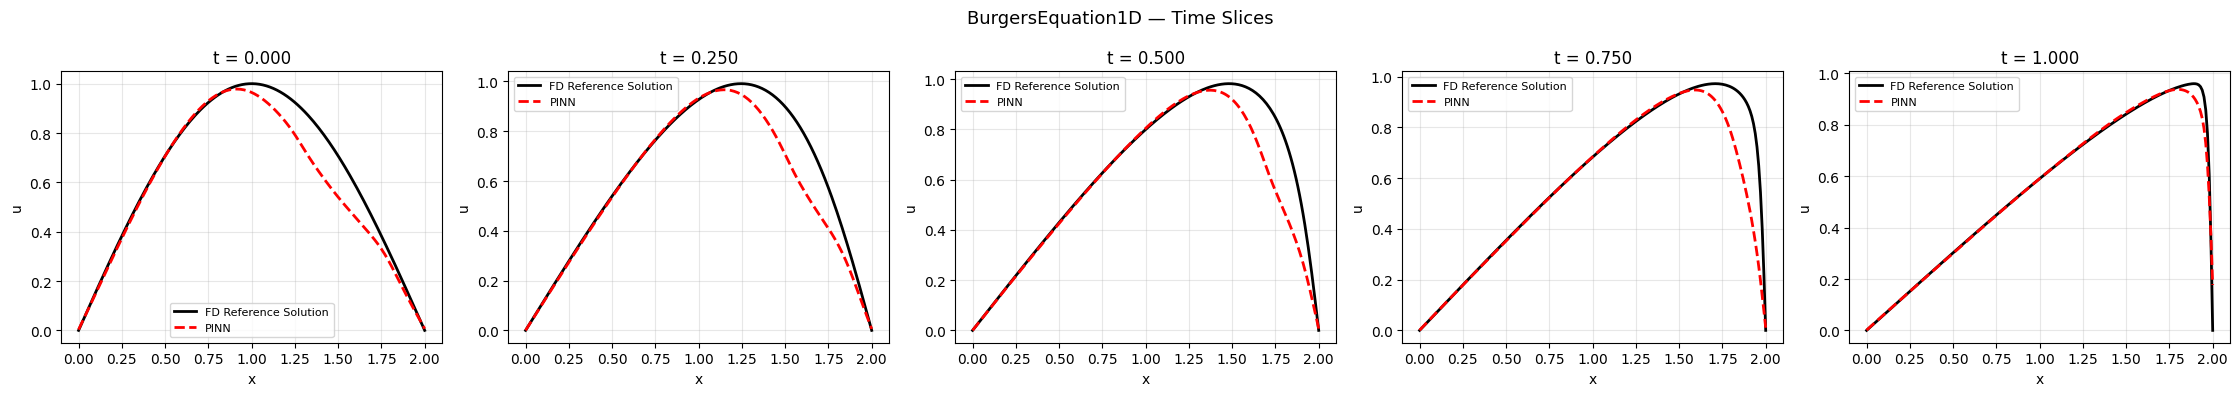

In [11]:
plot_time_slices(
    model=burgers_model_strong_forward,
    save_path='../results/burgers/forward_strong_slices.png'
)

### Weak form

In [50]:
# Prepare weak-form data
replacements = {'x_f': ('test_funcs', burgers_test_funcs), 't_f': ('test_doms', burgers_test_doms)}
burgers_data_weak = {}
for k, v in burgers_data.items():
    new_k, new_v = replacements.get(k, (k,v))
    burgers_data_weak[new_k] = new_v

# Define model
burgers_model_weak_forward = StrategicGeneralizedPINN(
    pde=burgers_pde,
    layers=[2, 50, 50, 50, 50, 1],  # DNN layers
    activation='tanh',              # Activation function
    inverse_params=None,            # Forward problem
    param_init=None,                # Use value from PDE
    device='cpu'
)

# Set to weak form
burgers_model_weak_forward.set_loss_strategy(
    GeneralizedWeakFormLoss(
        integration_method='gauss_legendre',    # Choice of integrator
        n_integration_points=15                 # Number of integration points
    )
)

GeneralizedPINN for BurgersEquation1D
  Network: [2, 50, 50, 50, 50] -> 1
  Total params: 7851
  Mode: Forward problem
    Fixed: nu=0.01
StrategicGeneralizedPINN initialized with GeneralizedStrongFormLoss
GeneralizedWeakFormLoss initialized:
  Method: gauss_legendre
  Points: 15
Loss strategy changed to GeneralizedWeakFormLoss


Trainer initialized:
  Loss strategy: GeneralizedWeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 6.328556e-01
  Residual: 9.029931e-07 (λ=1.00)
  Boundary: 1.019023e-02 (λ=1.00)
  Initial: 6.226644e-01 (λ=1.00)
  Non-zero weak residuals: 49

Epoch 1000/5000 (210.6s)
  Adam learning rate: 1.00e-03
  Total: 2.403496e-03
  Residual: 4.978551e-06 (λ=145.77)
  Boundary: 9.404681e-04 (λ=0.77)
  Initial: 1.615812e-03 (λ=0.59)
  Non-zero weak residuals: 49

Epoch 2000/5000 (425.4s)
  Adam learning rate: 1.00e-03
  Total: 2.230474e-04
  Residual: 4.042361e-07 (λ=143.13)
  Boundary: 1.079881e-04 (λ=0.76)
  Initial: 1.394887e-04 (λ=0.60)
  Non-zero weak residuals: 49

Epoch 3000/5000 (639.5s)
  Adam learning rate: 1.00e-03
  

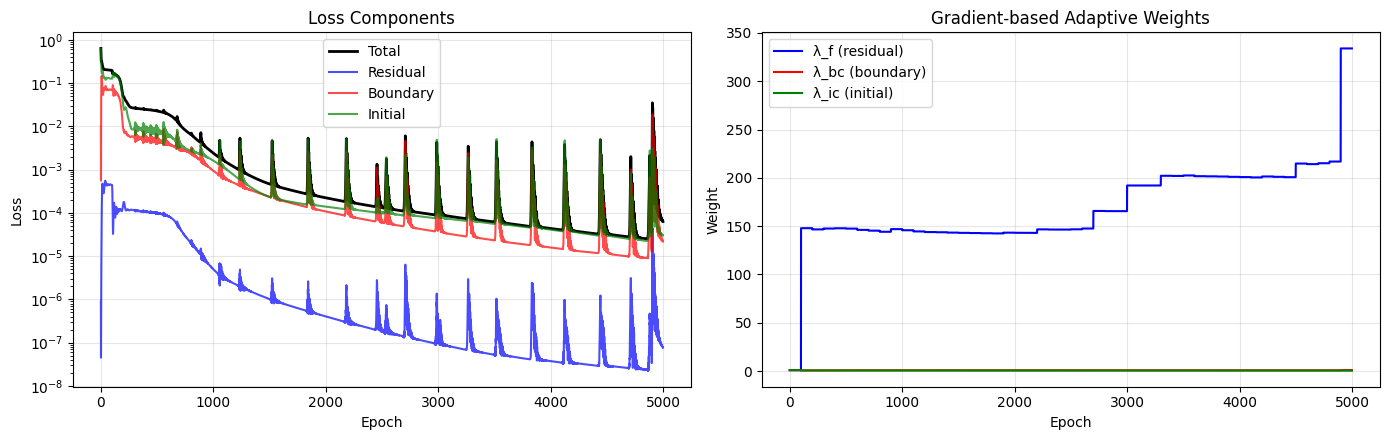


Training complete. Time: 1046.5s


In [51]:
burgers_trainer_weak_forward = StrategicPINNTrainer(
    model=burgers_model_weak_forward,
    data=burgers_data_weak,
    learning_rate=1e-3,
    reduce_lr_patience=100,
    switch_var=0.1,
    switch_slope=0.001,
    switch_window=200,
    min_adam_epochs=1000,
    track_gradient_norms=False,
    adaptive_weights=True,
)

# Train
burgers_trainer_weak_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=5000
)

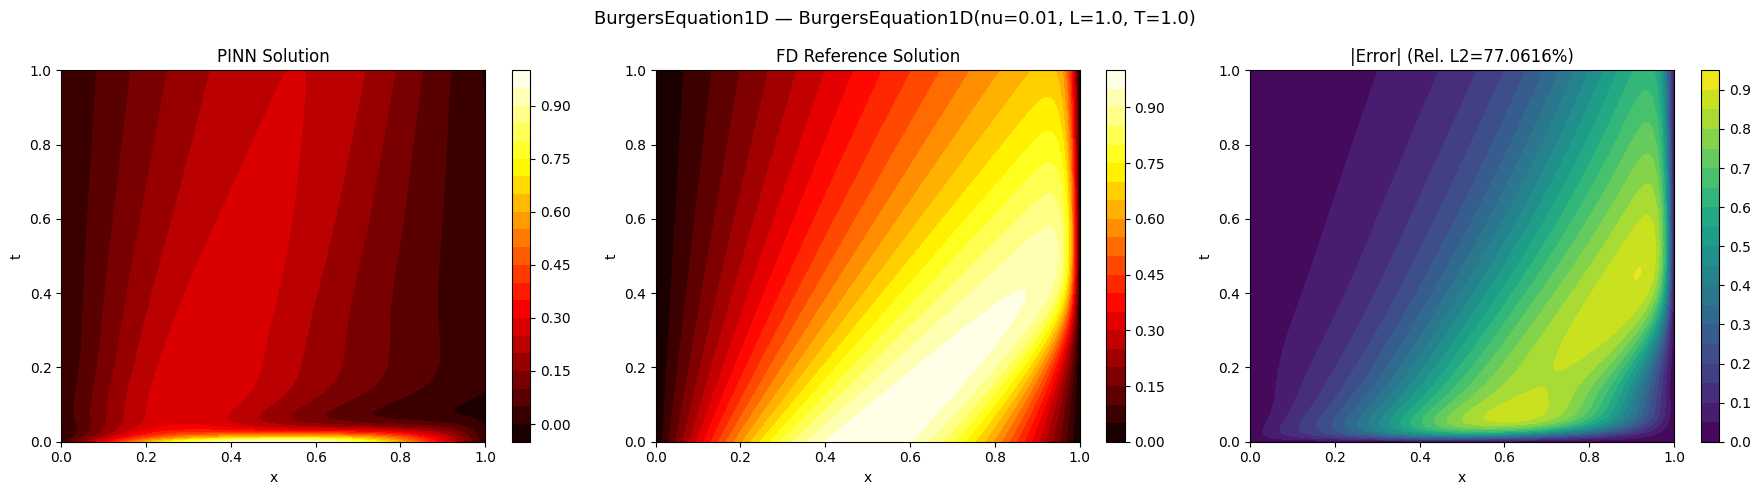

In [52]:
plot_solution(
    model=burgers_model_weak_forward,
    data=burgers_data_weak,
    save_path='../results/burgers/forward_weak_GL15_1040s'
)

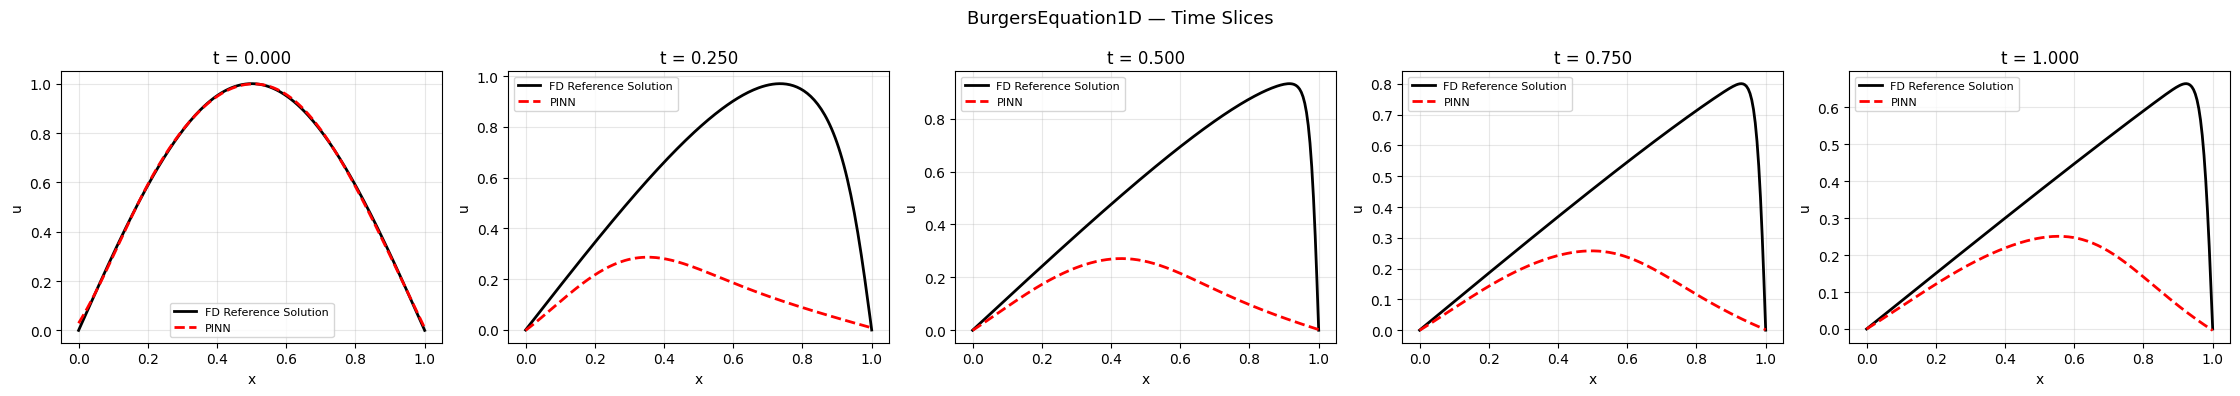

In [53]:
plot_time_slices(
    model=burgers_model_weak_forward
)